In [35]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px


import os 
import sys 

module_path = os.path.abspath(os.path.join(os.getcwd(), '../Main_modules'))
sys.path.append(module_path)

import warnings 
import process 
from PyFolioC_classes import PyFolioC
warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell

In [36]:
# Jerome path : r'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DataBase.csv'
# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv'
df = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv')

df.set_index('ticker', inplace=True)

df.columns = pd.to_datetime(df.columns.str[1:], format='%Y%m%d').strftime('%d/%m/%Y')

df_cleaned = df.dropna() # Utilisez la méthode fillna(0) pour remplacer les NaN par 0

df_cleaned = df_cleaned.transpose() ## WE WANT COLUMNS TO BE VECTOR OF RETURN FOR A GIVEN TICKER

df_cleaned.iloc[5025,:]

ticker
AA     0.006530
ABM   -0.010814
ABT    0.004153
ADI    0.000168
ADM    0.008015
         ...   
XLY    0.003114
XOM    0.010951
XRX    0.002444
YUM    0.000596
ZTR    0.000000
Name: 31/12/2019, Length: 663, dtype: float64

In [27]:
most_corr_df = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/Most correlated/most_corr_df.csv')
most_corr_df

,contribution cluster 1,contribution cluster 2,contribution cluster 3,contribution cluster 4,contribution cluster 5,contribution cluster 6,contribution cluster 7,contribution cluster 8,contribution cluster 9,contribution cluster 10,...,contribution cluster 15,contribution cluster 16,contribution cluster 17,contribution cluster 18,contribution cluster 19,contribution cluster 20,contribution cluster 21,contribution cluster 22,contribution cluster 23,contribution cluster 24
0,0.259910,0.036558,-0.175183,0.030139,0.021520,0.187492,0.839073,0.085088,-0.015232,-0.302099,...,0.121824,0.124392,-0.215847,0.062524,0.017868,0.039863,7.769798e-03,-0.037793,-0.014515,0.029371
1,-0.030996,0.066746,0.137020,-0.006881,0.058929,-0.015201,0.146395,0.089802,-0.419635,0.046917,...,0.141710,0.031894,-0.004993,0.132675,0.042971,0.063975,-3.838341e-02,-0.002867,0.115951,0.078912
2,-0.113655,0.397634,0.112694,0.000374,0.096723,0.073251,0.057617,0.218040,0.009030,0.003384,...,-0.153529,0.219414,0.022834,-0.067021,-0.010379,-0.025299,9.838018e-02,-0.023102,-0.006446,-0.007170
3,0.048935,0.510576,-0.498992,0.065590,-0.076258,-0.371205,0.261807,0.089078,0.423589,0.224705,...,0.050297,0.028313,0.063727,0.133641,-0.013069,-0.025708,6.368953e-01,0.154104,-0.399519,-0.000592
4,-2.279000,4.328190,-11.461893,0.008837,-2.262449,-0.813786,0.356607,0.529340,3.472771,-6.240490,...,-6.817168,14.680561,1.508978,-0.024184,0.055247,-1.070993,-4.486258e+00,-0.333353,-0.032004,-0.049740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0.029506,-0.015136,0.322217,-0.031723,-0.103428,0.039602,0.208339,-0.072306,0.492225,0.038681,...,0.009625,-0.078514,-0.048423,0.376428,0.097440,0.114280,-3.759182e-07,-0.011156,-0.147698,-0.068077
348,-0.008024,-0.007119,0.079006,-0.068397,0.196164,0.099155,0.116308,0.077238,0.009720,-0.045778,...,0.101304,-0.005827,0.008171,0.037133,-0.011225,0.048620,1.140578e-01,0.029816,-0.014574,0.017096
349,0.001203,0.292500,0.000053,0.072923,-0.001367,0.054664,-0.012049,-0.003452,0.141648,0.062249,...,0.093282,-0.003261,0.004776,0.144177,0.010621,0.106941,1.129564e-02,0.012781,0.066958,0.000512
350,0.241643,0.211886,-0.010483,0.057412,0.028184,0.027684,-0.079817,0.081837,-0.148522,-0.055634,...,0.059203,-0.006645,0.117685,0.046656,0.002861,-0.036705,1.311253e-01,0.046463,0.133609,0.021919


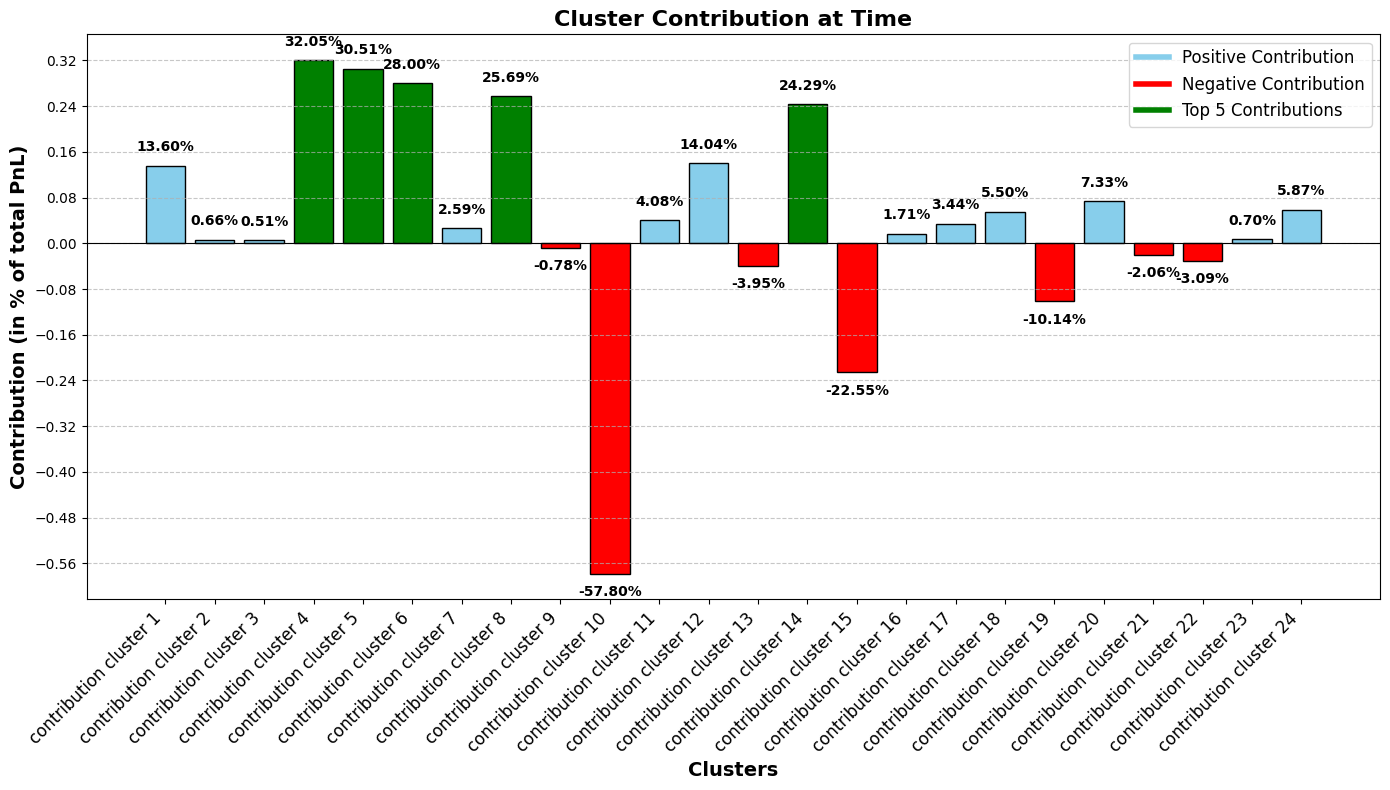

In [34]:
# Calculate the mean of the columns
col_means = most_corr_df.mean(axis=0)

# Identify the 5 highest values
top_5_indices = col_means.nlargest(5).index

# Define colors for the bars: red for negative values, blue for positive values, green for top 5
colors = ['green' if idx in top_5_indices else 'red' if val < 0 else 'skyblue' for idx, val in col_means.items()]

# Create a DataFrame for the bars with colors
df_col_means = pd.DataFrame({'Cluster': col_means.index, 'Contribution': col_means.values, 'Color': colors})

# Create the barplot
plt.figure(figsize=(14, 8))
bars = plt.bar(df_col_means['Cluster'], df_col_means['Contribution'], color=df_col_means['Color'], edgecolor='black')

# Add titles and labels
plt.title('Cluster Contribution at Time', fontsize=16, fontweight='bold')
plt.xlabel('Clusters', fontsize=14, fontweight='bold')
plt.ylabel('Contribution (in % of total PnL)', fontsize=14, fontweight='bold')

# Adjust x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add a grid for the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the y-axis scale for finer granularity
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=15))  # Adjust nbins for finer scale

# Add a horizontal line at zero for clarity
plt.axhline(0, color='black', linewidth=0.8)

# Add a legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='skyblue', lw=4, label='Positive Contribution'),
    Line2D([0], [0], color='red', lw=4, label='Negative Contribution'),
    Line2D([0], [0], color='green', lw=4, label='Top 5 Contributions')
]
plt.legend(handles=legend_elements, fontsize=12, loc='best')

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{100*yval:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width()/2, yval - 0.02, f'{100*yval:.2f}%', ha='center', va='top', fontsize=10, fontweight='bold')

# Adjust margins to avoid label overlap
plt.tight_layout()

# Show the plot
plt.show()

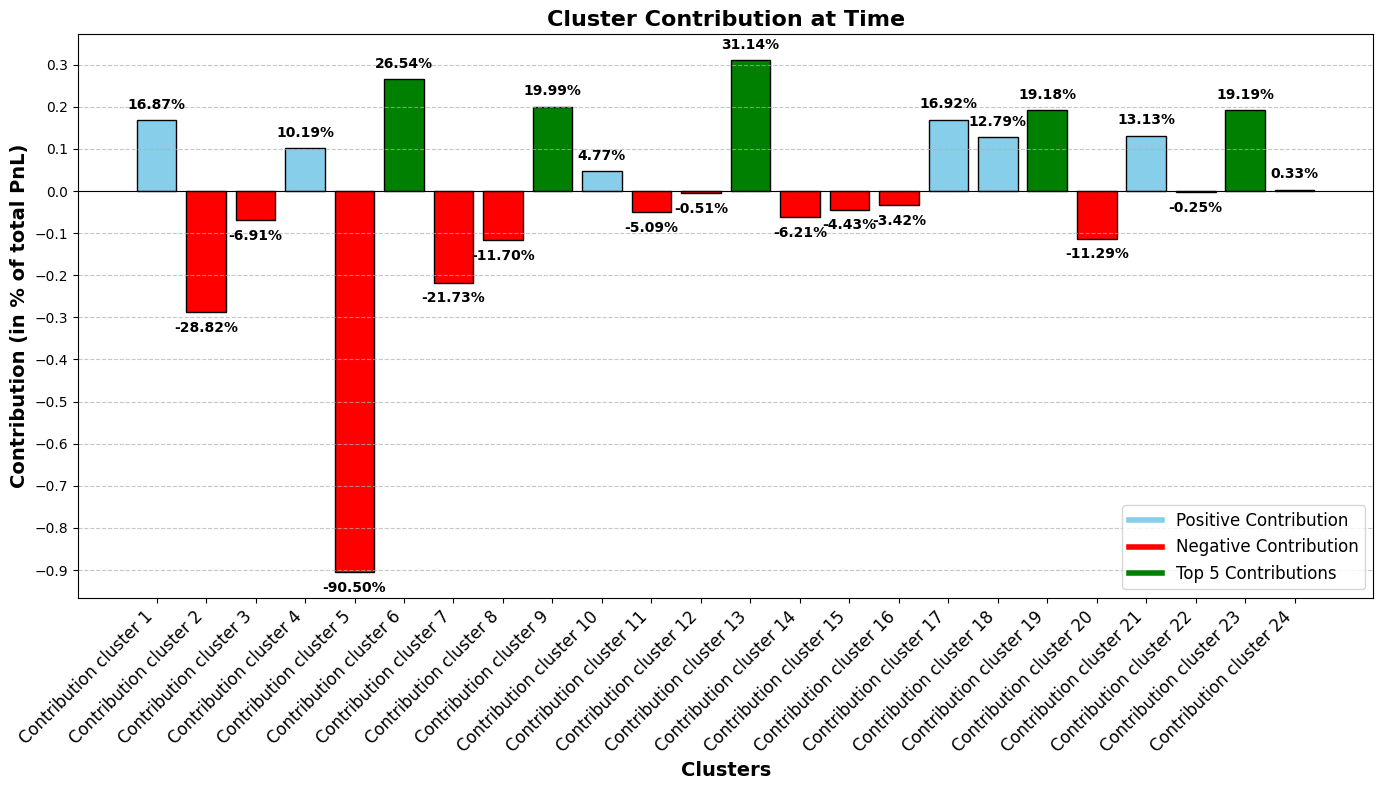

In [46]:
most_corr_df = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/Most correlated/most_corr_penalised.csv')
most_corr_df

# Calculate the mean of the columns
col_means = most_corr_df.mean(axis=0)

# Identify the 5 highest values
top_5_indices = col_means.nlargest(5).index

# Define colors for the bars: red for negative values, blue for positive values, green for top 5
colors = ['green' if idx in top_5_indices else 'red' if val < 0 else 'skyblue' for idx, val in col_means.items()]

# Create a DataFrame for the bars with colors
df_col_means = pd.DataFrame({'Cluster': col_means.index, 'Contribution': col_means.values, 'Color': colors})

# Create the barplot
plt.figure(figsize=(14, 8))
bars = plt.bar(df_col_means['Cluster'], df_col_means['Contribution'], color=df_col_means['Color'], edgecolor='black')

# Add titles and labels
plt.title('Cluster Contribution at Time', fontsize=16, fontweight='bold')
plt.xlabel('Clusters', fontsize=14, fontweight='bold')
plt.ylabel('Contribution (in % of total PnL)', fontsize=14, fontweight='bold')

# Adjust x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add a grid for the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the y-axis scale for finer granularity
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=15))  # Adjust nbins for finer scale

# Add a horizontal line at zero for clarity
plt.axhline(0, color='black', linewidth=0.8)

# Add a legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='skyblue', lw=4, label='Positive Contribution'),
    Line2D([0], [0], color='red', lw=4, label='Negative Contribution'),
    Line2D([0], [0], color='green', lw=4, label='Top 5 Contributions')
]
plt.legend(handles=legend_elements, fontsize=12, loc='best')

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{100*yval:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width()/2, yval - 0.02, f'{100*yval:.2f}%', ha='center', va='top', fontsize=10, fontweight='bold')

# Adjust margins to avoid label overlap
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
##################################################################### PARAMETERS #####################################################################
historical_data = df_cleaned
number_of_repetitions = 10
lookback_window = [3190,3265]  ## new lookback_window
evaluation_window = 5
number_of_clusters = 24
cov_method = 'SPONGE'
sigma = 0.01 ## on a fait bouger sigma ici
eta = 0.01
markowitz_type = 'expected_returns'
beta = 0.9
K = 4  # Number of fold for the cross validation
tc=0.0001

##################################################################### PORTFOLIO ######################################################################
portfolio = PyFolioC(number_of_repetitions=number_of_repetitions, historical_data=historical_data, lookback_window=lookback_window, evaluation_window=evaluation_window, number_of_clusters=number_of_clusters, sigma=sigma, eta=eta, EWA_cov=True, beta=beta, short_selling=True, cov_method=cov_method, markowitz_type=markowitz_type, transaction_cost_rate=tc)
## year 2008-2009 ==> 2007:2262 if evaluation_window == 2
## year 2008-2009 ==> 2007:2265 if evaluation_window == 5
## year 2012-2013 ==> 3016:3265
## year 2018-2019 ==> 4524:4774
## year 2016-2019 ==> 4021:4774
## year 2010-2020 ==> 2512:5279 (we go until 5277 to have a multiple of 5 for the difference)
######### year 2013-2019 ==> 3265:5025 352 window of 5

In [39]:
def calculate_mean_correlation(df):
    """
    Calculate the average correlation between columns of a DataFrame and optionally plot a heatmap.
    Args:
        df (pd.DataFrame): The DataFrame containing the data to analyze.
    Returns:
        float: The average correlation between columns of the DataFrame.
    """
    if df.empty:
        raise ValueError("The DataFrame is empty. Please provide a valid DataFrame.")
    
    correlation_matrix = df.corr()
    correlation_values = correlation_matrix.values
    n = correlation_values.shape[0]

    total_correlation = 0
    count = 0
    
    for i in range(n):
        for j in range(i + 1, n):
            total_correlation += correlation_values[i, j]
            count += 1

    mean_correlation = total_correlation / count if count != 0 else 0
    return mean_correlation

def get_most_corr_cluster(portfolio, lookback_window, df_cleaned, number=1, strat='correlation'):

    '''
    return the number-th most correlated cluster
    '''

    mean_corr_list = []

    for name, cluster in portfolio.cluster_composition.items():
        tickers = cluster['tickers']
        tickers_df = df_cleaned[tickers].iloc[lookback_window[0]:lookback_window[1], :]
        mean_corr = calculate_mean_correlation(tickers_df)
        mean_corr_list.append((name, mean_corr, tickers))

    sorted_cluster_corr_list = sorted(mean_corr_list, key=lambda x: x[1])
    most_corr_cluster = sorted_cluster_corr_list[-number]

    return most_corr_cluster

def most_corr_returns(portfolio, lookback_window, evaluation_window, df_cleaned, number=1):
    
    # tuple of length 3: (cluster name, average correlation, cluster composition)
    most_corr_cluster = get_most_corr_cluster(portfolio, lookback_window, df_cleaned, number)
    cluster_name = most_corr_cluster[0]
    ticker_list = most_corr_cluster[2]

    # we prepare an empty dataset
    most_corr_cluster_returns = pd.DataFrame(
        index=df_cleaned.index[lookback_window[1]:lookback_window[1]+evaluation_window], 
        columns=[cluster_name], 
        data=np.zeros((evaluation_window, 1))
    )

    for ticker in ticker_list:
        most_corr_cluster_returns[cluster_name] += df_cleaned[ticker][lookback_window[1]:lookback_window[1]+evaluation_window] * portfolio.consolidated_weight[ticker].values[0]

    return most_corr_cluster_returns

def most_corr_PnL(consolidated_portfolio, lookback_window, evaluation_window, df_cleaned, number=1):

    most_corr_return = most_corr_returns(consolidated_portfolio, lookback_window, evaluation_window, df_cleaned, number)

    cumulative_returns = np.cumprod(1 + most_corr_return) * 1 - 1

    return cumulative_returns.iloc[-1][0]


In [40]:
x = get_most_corr_cluster(portfolio, lookback_window, df_cleaned)

In [45]:
df_cleaned.shape[1]

663

In [8]:
non_adjusted_returns = np.cumprod(portfolio.portfolio_return['return'] + 1) - 1 

In [13]:
x/non_adjusted_returns[-1]

0.003704408560364042